# Introduction

We need to present a strategic recommendation to Julia that is supported by data which she can then use for the upcoming category review however to do so we need to analyse the data to understand the current purchasing trends and behaviours. The client is particularly interested in customer segments and their chip purchasing behaviour. Consider what metrics would help describe the customers’ purchasing behaviour.

# Import Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# data analysis and wrangling

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visulisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# dates 
import datetime
from matplotlib.dates import DateFormatter

# text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re

# statistical analysis
from scipy.stats import ttest_ind

# warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
/kaggle/input/quantium-data-analytics-virtual-experience-program/PurchaseBehaviour.csv
/kaggle/input/quantium-data-analytics-virtual-experience-program/Transactions.csv


# Data Exploration 
***Data Preparation and Customer Analytics***

Conduct analysis on client's transaction dataset and identify customer purchasing behaviours to generate insights and provide commercial recommendations.

# Load Data

In [3]:
# Import dataset
customer_df = pd.read_csv('../input/quantium-data-analytics-virtual-experience-program/PurchaseBehaviour.csv')
txn_df = pd.read_csv('../input/quantium-data-analytics-virtual-experience-program/Transactions.csv')

# Transaction Data

In [4]:
txn_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
txn_df.shape

(264836, 8)

In [6]:
# 'TXN_ID' is not unique to each row which means a customer can buy miltiple brands of chips in a single transaction
# Each row of the data corrosponds to purchase of single brand of chips and a customer can buy multiple brands in one single transaction

txn_df['TXN_ID'].nunique()


263127

In [7]:
# Look for duplicated 'TXN_ID'

txn_df[txn_df['TXN_ID'].duplicated()].head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.6
377,43475,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4
419,43391,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
476,43351,16,16427,14546,81,Pringles Original Crisps 134g,1,3.7
511,43315,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6


In [8]:
# Let's have a look at 'TXN_ID' 48887

txn_df.loc[txn_df['TXN_ID'] == 48887, : ]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
41,43605,55,55073,48887,4,Dorito Corn Chp Supreme 380g,1,3.25
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.60


In [9]:
txn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


<AxesSubplot:>

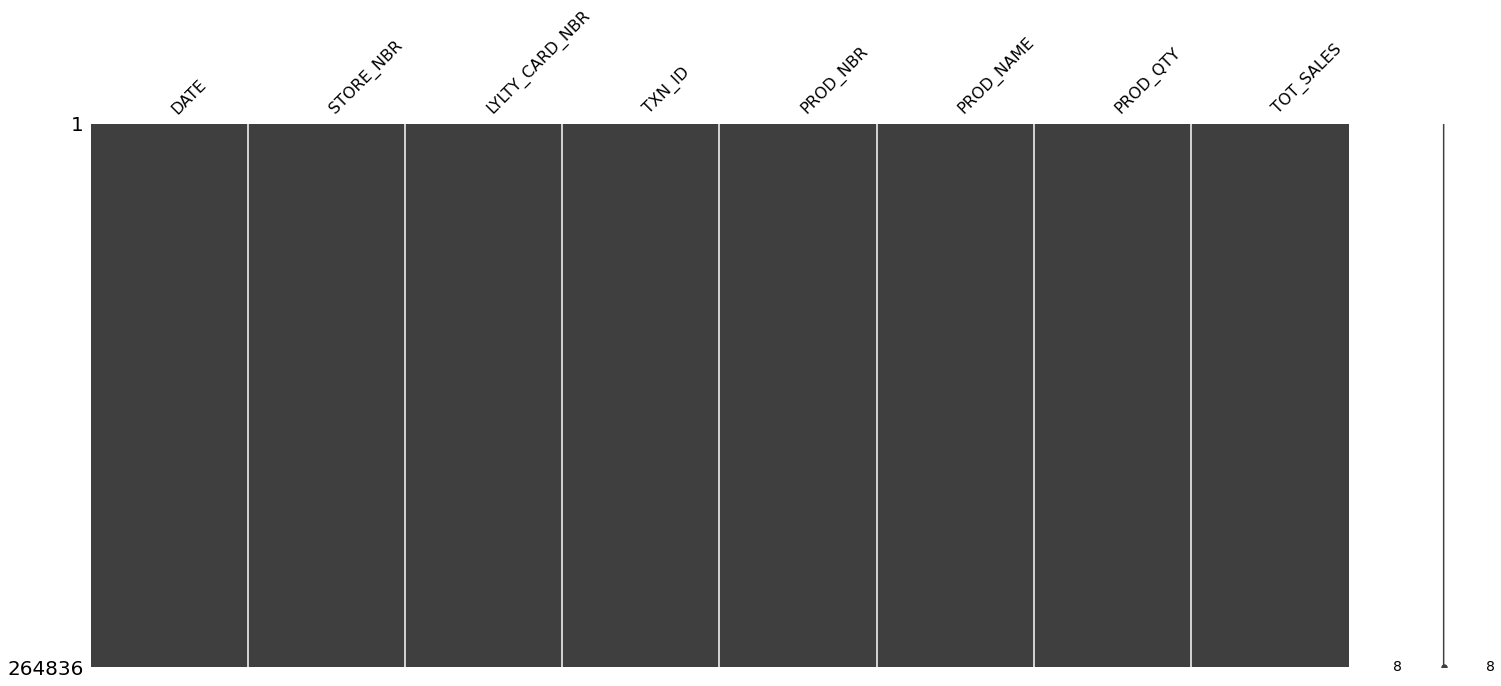

In [10]:
# Plot graph of missing values for  'txn_df'
missingno.matrix(txn_df)

No missing numbers in transaction data 

# *Data Preperation and Clenzing*

**Data Credibility Checking Using ROCCC Method**

1. N/A: Not Applicable as the dataset was generated from hypothetical customers.
2. Reliability: N/A
3. Original: N/A
4. Comprehensive: N/A
5. Current: N/A
6. Cited: N/A

# Examining Transaction Data

***Data Preperation***

* It is required to prepare data before cleaning because of the following reasons:

* Transform to correct datatype : To ensure that columns feature are in correct datatype, e,g., date in datetime, etc.

* Missing value detection

* Understanding dataset values



**Pre-dataset Analysis:**

* Date column was in integer format (Amount of days after December 30th 1899). Changed date column to datetime data type.
* Ensuring all products are Chips. Split and counted frequency of each word in "PROD_NAME" column. Removed all rows containing "salsa" in "PROD_NAME".
* Removed outliers rows in "PROD_QTY" column.
* Value counted each first word in "PROD_NAME" column to extract brand name. Combined brands written in multiple ways.
* Created new column "Cleaned_Brand_Names".

In [11]:
# Let's explore individual featurers in both data set 
# starting with 'txn_df' - Transaction dataset

list(txn_df.columns)

['DATE',
 'STORE_NBR',
 'LYLTY_CARD_NBR',
 'TXN_ID',
 'PROD_NBR',
 'PROD_NAME',
 'PROD_QTY',
 'TOT_SALES']

In [12]:
txn_df['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [13]:
# 'DATE' is not in right format 

txn_df['DATE'] = pd.to_datetime(txn_df['DATE'],errors='coerce',unit='d',origin='1899-12-30')

In [14]:
# Check the first five rows of the new feature

txn_df['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [15]:
# Data is now in right format

txn_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [16]:
# Let's move on to 'PROD_NAME' feature
txn_df['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [17]:
# Extract weights out of 'PROD_NAME'

txn_df['PACK_SIZE'] = txn_df['PROD_NAME'].str.extract("(\d+)")
txn_df['PACK_SIZE'] = pd.to_numeric(txn_df['PACK_SIZE'])
txn_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [18]:
# Creating text cleaning function for 'PROD_NAME'

def clean_text(text):
    text = re.sub('[&/]',' ',text) # remove special characters '&' and '/'
    text = re.sub('\d\w*',' ',text) # remove product weights
    return text



In [19]:
# Apply text cleaning function to 'PROD_NAME' column
txn_df['PROD_NAME'] = txn_df['PROD_NAME'].apply(clean_text)

In [20]:
# Creating a string and apply 'word_tokenize' to saperate the words

prod_name = txn_df['PROD_NAME']
string  = ''.join(prod_name)
tokenized_prod_name = word_tokenize(string)

In [21]:
# Apply 'fdist' function which computes thev frequency of each token and put it into a dataframe

word_freq = fdist(tokenized_prod_name)
freq_df = pd.DataFrame(list(word_freq.items()), columns = ['Word', 'Frequency']).sort_values(by = 'Frequency', ascending = False)

In [22]:
# Let's see the top 5 most frequent words

freq_df.head()

,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743


In [23]:
# Drop rows with salsa word in 'PROD_NAME'

txn_df['PROD_NAME'] = txn_df['PROD_NAME'].apply(lambda x : x.lower())
txn_df = txn_df[~txn_df['PROD_NAME'].str.contains('salsa')]
txn_df['PROD_NAME'] = txn_df['PROD_NAME'].apply(lambda x: x.title())


In [24]:
# Checking for changes

txn_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150


In [25]:
# Let's explore 'PROD_QTY' and 'TOT_SALES' features

txn_df['PROD_QTY'].value_counts()

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

2 outliers (value = 200) in PROD_QTY will be removed. Both entries are by the same customer,
we will examine this customer’s other transactions.

In [26]:
# We have two occurance f 200 in the dataset
# Let's explore further

txn_df.loc[txn_df['PROD_QTY']== 200, : ]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380



Both these transactions have been made by the same person at the same store. Let's see all the transactions this person has made by tracking his loyalty card number.

In [27]:
txn_df.loc[txn_df['LYLTY_CARD_NBR'] == 226000, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


It looks like this customer has only had the two transactions over the year and is not an ordinary
retail customer. The customer might be buying chips for commercial purposes instead. We’ll
remove this loyalty card number from further analysis.

In [28]:
txn_df.drop(txn_df.index[txn_df['LYLTY_CARD_NBR'] == 226000], inplace = True)
customer_df.drop(customer_df.index[customer_df['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [29]:
# Checking for changes

txn_df.loc[txn_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE


In [30]:
# Now let's examine the number of transactions over time to see if there are any obvious data issues e.g. missing data

txn_df['DATE'].nunique()

364

In [31]:
# Look for the missing date 
min_date = txn_df['DATE'].min()
max_date = txn_df['DATE'].max()
pd.date_range(start = min_date, end = max_date).difference(txn_df['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

Using the difference method we see that 2018-12-25 was the missing date. 
We have a missing date on Christmas Day. This makes sense because most retail stores are closed that day.

In [32]:
# Create a new dataframe which contains the total sale for each date

a = pd.pivot_table(txn_df, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.head()

,TOT_SALES
DATE,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [33]:
b = pd.DataFrame(index = pd.date_range(start = min_date, end = max_date))
b['TOT_SALES'] = 0
len(b)

365

In [34]:
c = a + b
c.fillna(0, inplace = True)

In [35]:
c.head()

,TOT_SALES
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [36]:

c.index.name = 'Date'
c.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
c.head()

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


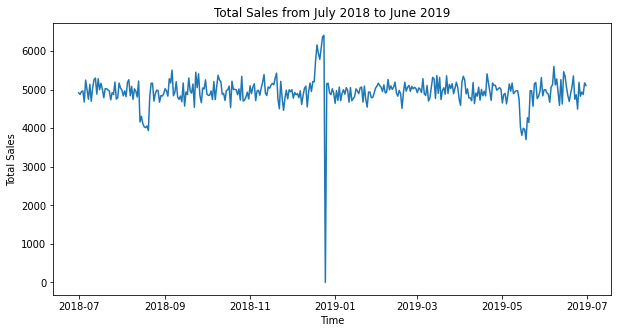

In [37]:
timeline = c.index
graph = c['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

We can see that sales spike up during the December month and zero sale on Christmas Day.

In [38]:
# Confirm the date where sales count equals to zero

c[c['Total Sales'] == 0]

,Total Sales
Date,
2018-12-25,0.0


In [39]:
# Let's look at the December month only

c_december = c[(c.index < "2019-01-01") & (c.index > "2018-11-30")]
c_december.head()

,Total Sales
Date,
2018-12-01,5000.9
2018-12-02,4781.1
2018-12-03,4927.0
2018-12-04,4869.4
2018-12-05,4900.5


Text(0.5, 1.0, 'Total Sales in December')

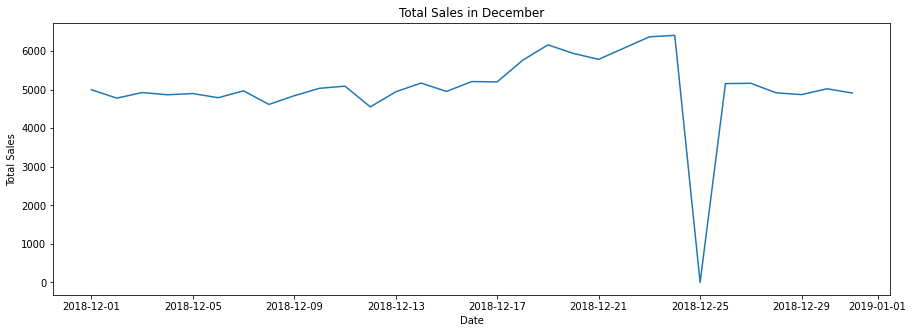

In [40]:
plt.figure(figsize = (15, 5))
plt.plot(c_december)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales in December')

In [41]:
# Reset index

c_december.reset_index(drop = True, inplace = True)
c_december.head()

,Total Sales
0,5000.9
1,4781.1
2,4927.0
3,4869.4
4,4900.5


In [42]:
# Relabel Date

c_december['Date'] = c_december.index + 1
c_december.head()

,Total Sales,Date
0,5000.9,1
1,4781.1,2
2,4927.0,3
3,4869.4,4
4,4900.5,5


<AxesSubplot:xlabel='Date', ylabel='Total Sales'>

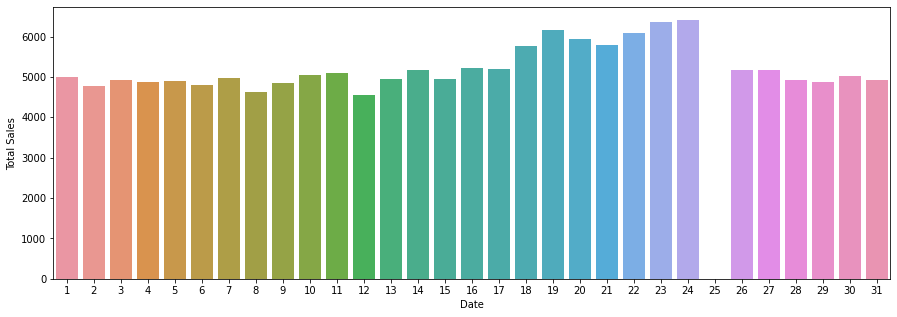

In [43]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Total Sales', data = c_december)


Now, we move on to PACK_SIZE that we created at the beginning by extracting the weight from the PROD_NAME column.

In [44]:
txn_df['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [45]:
txn_df['PACK_SIZE'].unique()

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70])

Text(0.5, 1.0, 'Pack Size Histogram')

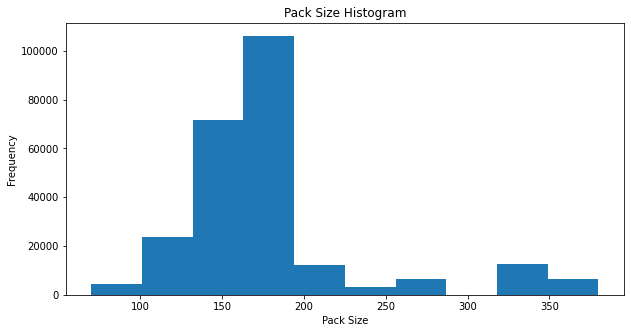

In [46]:
# Check the distribution of PACK_SIZE

plt.figure(figsize = (10, 5))
plt.hist(txn_df['PACK_SIZE'])     
plt.xlabel('Pack Size')
plt.ylabel('Frequency')
plt.title('Pack Size Histogram')

In [47]:
txn_df['PACK_SIZE'].describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_SIZE, dtype: float64

Product pack size looks reasonable with highest transaction frequency in mid-sized pack. Smallest
size is 70g, and biggest size is 380g.

In [48]:
# Extract brand name from PROD_NAME and create new column called BRAND

part = txn_df['PROD_NAME'].str.partition()
txn_df['BRAND'] = part[0]
txn_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,Ccs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle


In [49]:
txn_df['BRAND'].unique()

array(['Natural', 'Ccs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Ww', 'Thins', 'Burger', 'Ncc', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'Grnwves',
       'Tyrrells', 'Cobs', 'French', 'Rrd', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

Some of the brand names look like they are of the same brands - such as RED and RRD, which are
both Red Rock Deli chips. Dorito and Doritos. Grain and GrnWves. Infuzions and Infzns. Natural
and NCC. Smith and Smiths. Snbts and Sunbites. WW and Woolworth

In [50]:

# Rename brand names for consistency

txn_df['BRAND'].replace('Ncc', 'Natural', inplace = True)
txn_df['BRAND'].replace('Ccs', 'CCS', inplace = True)
txn_df['BRAND'].replace('Smith', 'Smiths', inplace = True)
txn_df['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
txn_df['BRAND'].replace('Dorito', 'Doritos', inplace = True)
txn_df['BRAND'].replace('Ww', 'Woolworths', inplace = True)
txn_df['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
txn_df['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
txn_df['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

txn_df['BRAND'].unique()


array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [51]:
# Which brand had the most sales?

txn_df.groupby('BRAND').TOT_SALES.sum().sort_values(ascending = False)

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Grainwaves        51617.2
Natural           42318.0
Woolworths        41059.1
Cheezels          40029.9
CCS               18078.9
Cheetos           16884.5
Sunbites           9676.4
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

In [52]:
d = pd.pivot_table(txn_df, values = 'TOT_SALES', index = 'BRAND', aggfunc = 'sum')
d.head()

,TOT_SALES
BRAND,
Burger,6831.0
CCS,18078.9
Cheetos,16884.5
Cheezels,40029.9
Cobs,70569.8


Text(0.5, 1.0, 'Total Sales per Brand')

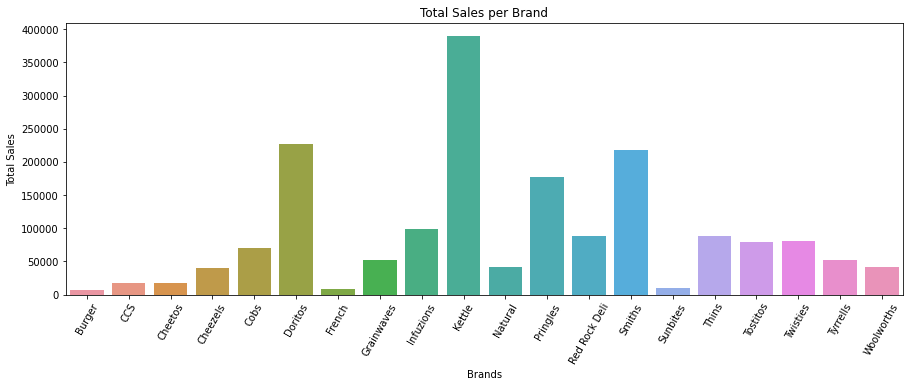

In [53]:
plt.figure(figsize = (15,5))
plt.xticks(rotation = 60)
sns.barplot(x = d.index, y ='TOT_SALES', data = d)
plt.xlabel('Brands')
plt.ylabel('Total Sales')
plt.title('Total Sales per Brand')


Most popular brand is 'Kettle'.

# Customer Data

In [54]:
list(customer_df.columns)

['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']

In [55]:
customer_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


<AxesSubplot:>

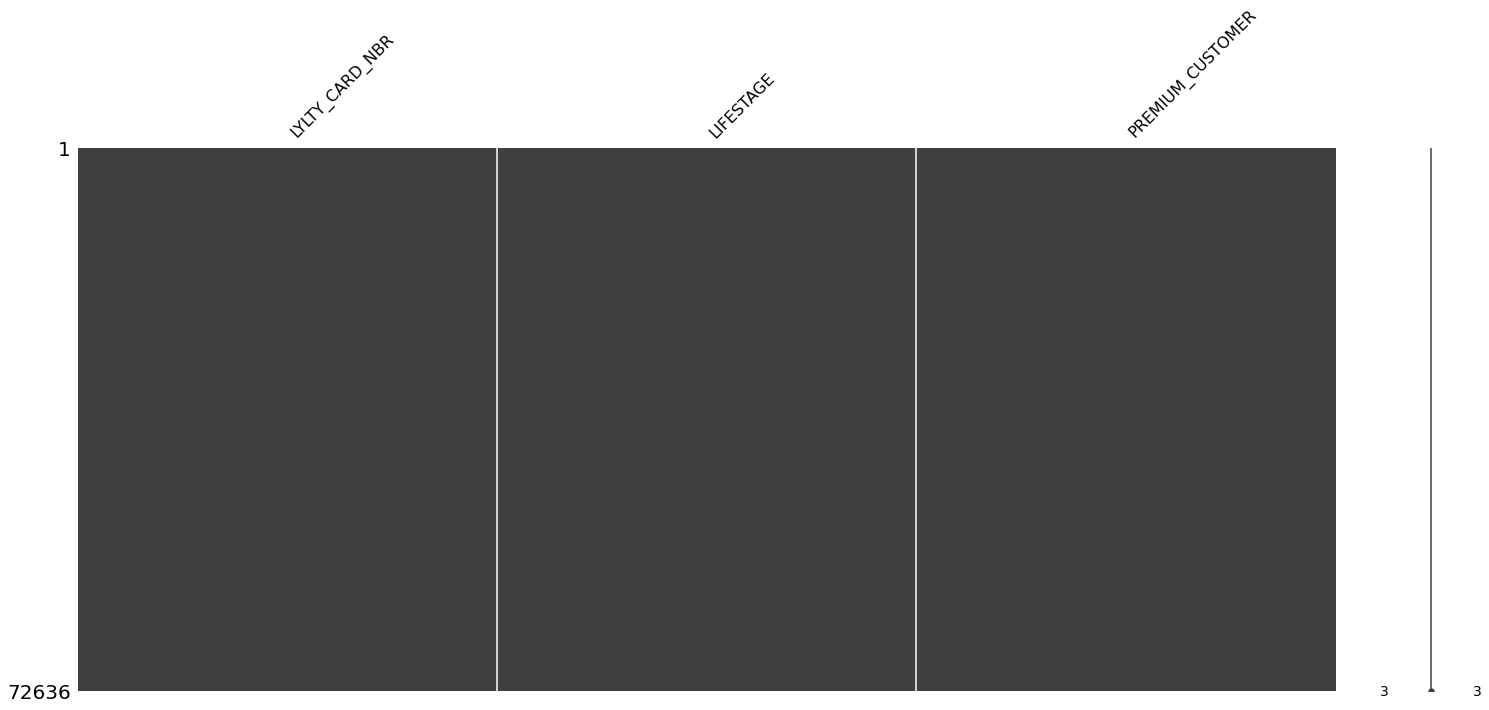

In [56]:
# Missing values in customerData

missingno.matrix(customer_df)

In [57]:
customer_df.shape

(72636, 3)

Since the number of rows in 'customer_df' is equal to number of unique loyalty card number, we conclude that loyalty card numbers are unique to each row.

In [58]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72636 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72636 non-null  int64 
 1   LIFESTAGE         72636 non-null  object
 2   PREMIUM_CUSTOMER  72636 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [59]:
# How many unique lifestages?

customer_df['LIFESTAGE'].nunique()

7

In [60]:

# What are those lifestages?

customer_df['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [61]:
# Value counts for lifestages

customer_df['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

<AxesSubplot:xlabel='count', ylabel='LIFESTAGE'>

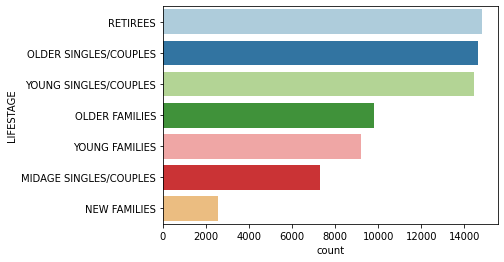

In [62]:
sns.set_palette('Paired')
sns.countplot(y = customer_df['LIFESTAGE'], order = customer_df['LIFESTAGE'].value_counts().index)


In [63]:
# How many unique premium customer categories?

customer_df['PREMIUM_CUSTOMER'].nunique()

3

In [64]:
# Value counts for each premium customer category

customer_df['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

Text(0, 0.5, 'Premium Customer')

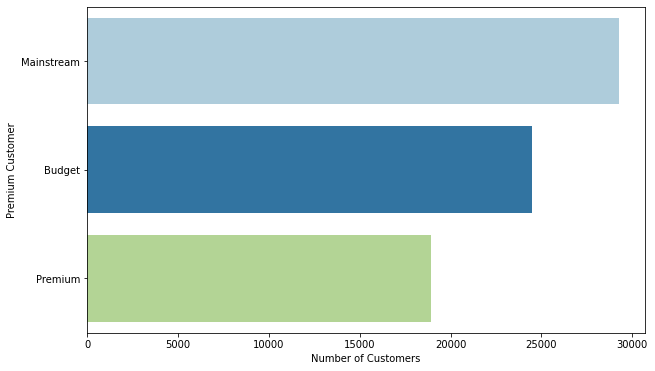

In [65]:
plt.figure(figsize = (10, 6))
sns.countplot(y = customer_df['PREMIUM_CUSTOMER'], order = customer_df['PREMIUM_CUSTOMER'].value_counts().index)
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer')

In [66]:
# Merge transactionData and customerData together

combine_data = pd.merge(txn_df, customer_df)

In [67]:

print("Transaction data shape: ", txn_df.shape)
print("Customer data shape: ", customer_df.shape)
print("Combined data shape: ", combine_data.shape)

Transaction data shape:  (246740, 10)
Customer data shape:  (72636, 3)
Combined data shape:  (246740, 12)


In [68]:
# Check for null values

combine_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

#  Data analysis on customer segments 

**Analysis Criteria**

- Who spends the most on chips (total sales), describing customers by lifestage and
- how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment


In [69]:
# Total sales by PREMIUM_CUSTOMER and LIFESTAGE

sales = pd.DataFrame(combine_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            156863.75
Mainstream       YOUNG SINGLES/COUPLES     147582.20
                 RETIREES                  145168.95
Budget           YOUNG FAMILIES            129717.95
                 OLDER SINGLES/COUPLES     127833.60
Mainstream       OLDER SINGLES/COUPLES     124648.50
Premium          OLDER SINGLES/COUPLES     123537.55
Budget           RETIREES                  105916.30
Mainstream       OLDER FAMILIES             96413.55
Premium          RETIREES                   91296.65
Mainstream       YOUNG FAMILIES             86338.25
                 MIDAGE SINGLES/COUPLES     84734.25
Premium          YOUNG FAMILIES             78571.70
                 OLDER FAMILIES             75242.60
Budget           YOUNG SINGLES/COUPLES      57122.10
Premium          MIDAGE SINGLES/COUPLES     54443.85
                 YOUNG SINGLES/COUPLES      39052.30
Budget           MIDAGE SINGLES/COUPLES     33345.70
                 NEW FAMILIES               20607.45
Mainstream       NEW FAMILIES               15979.70
Premium          NEW FAMILIES               10760.80

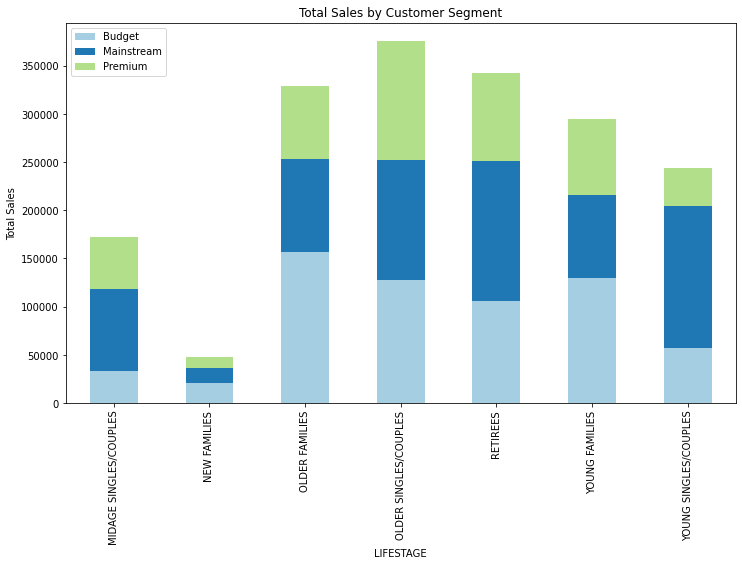

In [71]:
# Visualise

salesPlot = pd.DataFrame(combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Top 3 sales come from budget older families, mainstream young singles/couples and mainstream retirees.

In [72]:
# Number of customers by PREMIUM_CUSTOMER and LIFESTAGE

customers = pd.DataFrame(combine_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head(10)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 7917
                 RETIREES                              6358
                 OLDER SINGLES/COUPLES                 4858
Budget           OLDER SINGLES/COUPLES                 4849
Premium          OLDER SINGLES/COUPLES                 4682
Budget           OLDER FAMILIES                        4611
                 RETIREES                              4385
                 YOUNG FAMILIES                        3953
Premium          RETIREES                              3812
Budget           YOUNG SINGLES/COUPLES                 3647

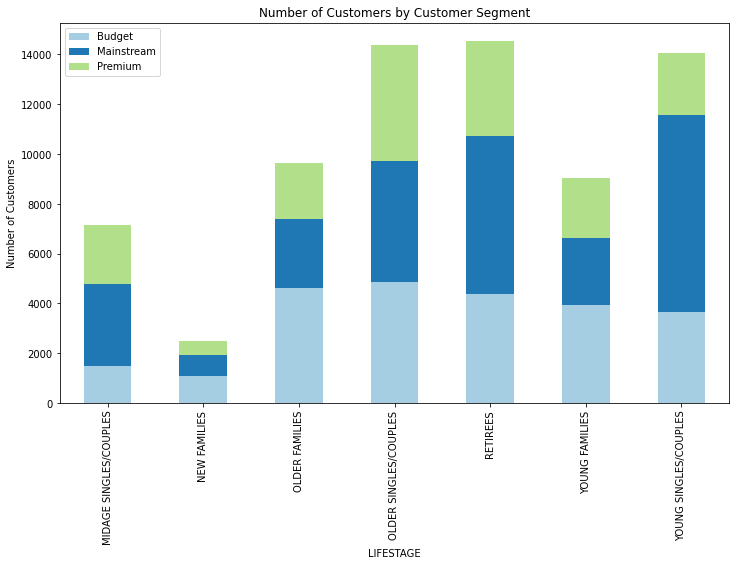

In [73]:
# Visualise

customersPlot = pd.DataFrame(combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
customersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Number of Customers by Customer Segment')
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

There are more mainstream young singles/couples and retirees. This contributes to to more chips sales in these segments however this is not the major driver for the budget older families segment.

In [75]:
# Average units per customer by PREMIUM_CUSTOMER and LIFESTAGE

avg_units = combine_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / combine_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


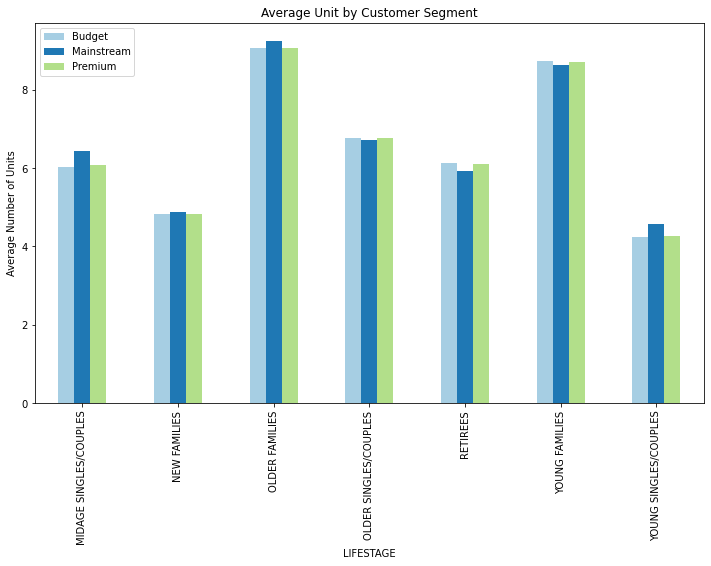

In [77]:
# Visualise 

avgUnitsPlot = pd.DataFrame(combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)


Older families and young families buy more chips per customer

In [78]:

# Average price per unit by PREMIUM_CUSTOMER and LIFESTAGE

avg_price = combine_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / combine_data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.074043
                 MIDAGE SINGLES/COUPLES        3.994449
                 NEW FAMILIES                  3.935887
Budget           RETIREES                      3.932731
                 NEW FAMILIES                  3.931969

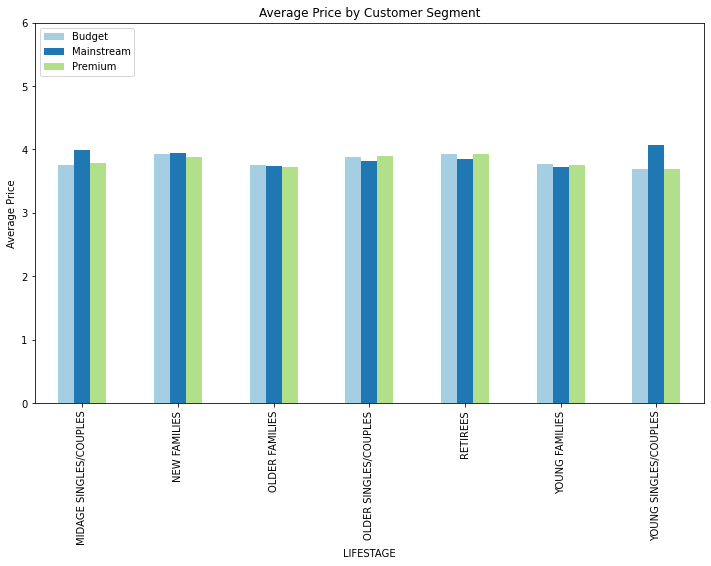

In [79]:
# Visualise 

avgPricePlot = pd.DataFrame(combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)


Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they do buy chips, it is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

In [80]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

# Create a new dataframe pricePerUnit
pricePerUnit = combine_data

# Create a new column under pricePerUnit called PRICE
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']

# Let's have a look
pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45


In [81]:
# Let's group our data into mainstream and non-mainstream

mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']

Text(0.5, 0, 'Price per Unit')

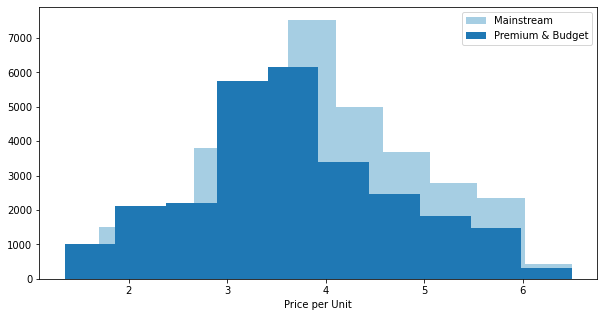

In [82]:
# Compare histograms of mainstream and non-mainstream customers

plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonMainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [83]:
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-mainstream average price per unit: ${:.2f}".format(np.mean(nonMainstream)))
if np.mean(mainstream) > np.mean(nonMainstream):
    print("Mainstream customers have higher average price per unit. ")
else:
    print("Non-mainstream customers have a higher average price per unit. ")

Mainstream average price per unit: $4.04
Non-mainstream average price per unit: $3.71
Mainstream customers have higher average price per unit. 


In [84]:
# Perform t-test 

ttest_ind(mainstream, nonMainstream)

Ttest_indResult(statistic=37.83196107667825, pvalue=2.235645611540966e-309)

We have found quite a few interesting insights that we can dive deeper into. For example, we might want to target customers segments that contribute the most to sales to retain them to further increase sales. Let's examine mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips.

In [85]:
target = combine_data.loc[(combine_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (combine_data['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = combine_data.loc[(combine_data['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (combine_data['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-10-02,1,1020,27,7,Smiths Crinkle Original,1,5.7,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.7
221347,2019-05-02,1,1020,28,84,Grnwves Plus Btroot Chilli Jam,1,3.1,180,Grainwaves,YOUNG SINGLES/COUPLES,Mainstream,3.1
221348,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221349,2019-02-07,1,1163,189,12,Natural Chip Co Tmato Hrb Spce,1,3.0,175,Natural,YOUNG SINGLES/COUPLES,Mainstream,3.0


# Affinity to brand

In [86]:
# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [87]:
# Merge the two dataframes together

brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger,0.002926,0.006538
CCS,0.011180,0.018445
Cheetos,0.008033,0.011759
Cheezels,0.017971,0.018904
Cobs,0.044638,0.038449


In [88]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
Tyrrells,0.031553,0.025715,1.227025
Twisties,0.046184,0.037933,1.217506
Doritos,0.122761,0.101171,1.213397
Kettle,0.197985,0.166560,1.188667
Tostitos,0.045411,0.038350,1.184100
Pringles,0.119420,0.101110,1.181090
Cobs,0.044638,0.038449,1.160959
Infuzions,0.064679,0.057410,1.126622
Thins,0.060373,0.057159,1.056217



Mainstream young singles/couples are more likely to purchase Tyrrells chips compared to other brands.

# Affinity to pack size

In [89]:
# Target segment 
targetSize = target.loc[:, ['PACK_SIZE', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PACK_SIZE')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget.loc[:, ['PACK_SIZE', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PACK_SIZE')['Non-Target Pack Affinity'].sum())

In [90]:
# Merge the two dataframes together

pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
PACK_SIZE,,
70,0.003037,0.006284
90,0.006349,0.012613
110,0.106280,0.089575
125,0.003009,0.005976
134,0.119420,0.101110


In [91]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_SIZE,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300


It looks like mainstream singles/couples are more likely to purchase a 270g pack size compared to other pack sizes.

In [93]:
# Which brand offers 270g pack size?

combine_data.loc[combine_data['PACK_SIZE'] == 270, :].head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
34,2019-05-18,9,9208,8634,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
79,2018-08-24,39,39167,35639,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
125,2019-05-06,54,54305,48304,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
132,2019-05-20,55,55073,48887,113,Twisties Chicken,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
209,2019-01-01,80,80182,78980,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
252,2018-11-18,84,84096,83672,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
253,2019-05-20,88,88320,87811,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
278,2018-07-11,102,102115,102207,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
347,2019-04-05,118,118007,120735,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
350,2018-07-01,119,119051,122360,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6


In [95]:
# Is Twisties the only brand who sells 270g pack size?

combine_data.loc[combine_data['PACK_SIZE'] == 270, 'BRAND'].unique()

array(['Twisties'], dtype=object)

Twisties is the only brand that offers 270g pack size.

# Insights

• Top 3 total sales contributor segment are:

1. Older families (Budget) $156,864

2. Young Singles/Couples (Mainstream) $147,582

3. Retirees (Mainstream) $145,169

• Young Singles/Couples (Mainstream) has the highest population, followed by Retirees (Main-
stream). Which explains their high total sales.

• Despite Older Families not having the highest population, they have the highest frequency of
purchase, which contributes to their high total sales.

• Older Families followed by Young Families has the highest average quantity of chips bought
per purchase.

• The Mainstream category of the “Young and Midage Singles/Couples” have the highest spending
of chips per purchase. And the difference to the non-Mainstream “Young and Midage Singles/Couples” are statistically significant.

• Chips brand Kettle is dominating every segment as the most purchased brand.

• Observing the 2nd most purchased brand, “Young and Midage Singles/Couples” is the only
segment with a different preference (Doritos) as compared to others’ (Smiths).

• Most frequent chip size purchased is 175gr followed by the 150g chip size for all segments.

# Conclusion

* Sales are highest for (Budget, OLDER FAMILIES), (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES)
* We found that (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) are mainly due to the fact that there are more customers in these segments
* (Mainstream, YOUNG SINGLES/COUPLES) are more likely to pay more per packet of chips than their premium and budget counterparts
* They are also more likely to purchase 'Tyrrells' and '270g' pack sizes than the rest of the population


# Reccomendations:

**Older Families** 
* Focus on the Budget segment.
* Strength: Frequent purchase. We can give promotions that encourages more frequency of purchase.
* Strength: High quantity of chips purchased per visit. We can give promotions that encourage them to buy more quantity of chips per purchase.

**Young Singles/Couples**
* Focus on the Mainstream segment.
* This segment is the only segment that had Doritos as their 2nd most purchased brand (after Kettle). To specifically target this segment it might be a good idea to collaborate with Doritos merchant to do some branding promotion catered to "Young Singles/Couples - Mainstream" segment.
* Strength: Population quantity. We can spend more effort on making sure our promotions reach them, and it reaches them frequently.

**Retirees**
* Focus on the Mainstream segment.
* Strength: Population quantity. Again, since their population quantity is the contributor to the high total sales, we should spend more effort on making sure our promotions reaches as many of them as possible and frequent.

**General**
* All segments has Kettle as the most frequently purchased brand, and 175gr (regardless of brand) followed by 150gr as the preferred chip size.
* When promoting chips in general to all segments it is good to take advantage of these two points.